## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [3]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'SNWD_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [4]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,-0.214842,0.118308,-0.092708,-0.229290
1,-0.177967,-0.155541,-0.106122,-0.221590
2,-0.274757,0.167597,-0.163774,-0.027604
3,-0.286767,-0.319420,0.105178,0.141286
4,-0.136296,0.040935,-0.254164,0.331384


In [5]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00486428', u'USC00488209', u'USC00485065', u'USC00480140', u'USC00488870']


,0,1,2,3
station,,,,
USC00486428,-0.214842,0.118308,-0.092708,-0.229290
USC00488209,-0.177967,-0.155541,-0.106122,-0.221590
USC00485065,-0.274757,0.167597,-0.163774,-0.027604
USC00480140,-0.286767,-0.319420,0.105178,0.141286
USC00488870,-0.136296,0.040935,-0.254164,0.331384


In [6]:
table=Eig.join(Stations,how='left')

In [7]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00486428,MOOSE,43.6536,-110.7169,1964.1,-0.214842,0.118308,-0.092708,-0.229290
USC00488209,SHOSHONI,43.2372,-108.1097,1474.3,-0.177967,-0.155541,-0.106122,-0.221590
USC00485065,KAYCEE 26 SSW,43.3500,-106.7667,1659.0,-0.274757,0.167597,-0.163774,-0.027604
USC00480140,ALTA 1 NNW,43.7728,-111.0339,1962.0,-0.286767,-0.319420,0.105178,0.141286


In [8]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

html_colors = []

for c in colors:
    if (c == 'b'):
        html_colors.append('blue')
    elif (c == 'g'):
        html_colors.append('green')    
    elif (c == 'r'):
        html_colors.append('red')
    elif (c == 'c'):
        html_colors.append('cyan')
    elif (c == 'm'):
        html_colors.append('magenta')
    elif (c == 'y'):
        html_colors.append('yellow')
    else:
        html_colors.append('black')
        
print html_colors

['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']


## Map

In [9]:
min_lat,max_lat,min_long,max_long = box = (table['latitude'].min(), table['latitude'].max(), 
                                           table['longitude'].min(), table['longitude'].max())
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(url=u'https://api.mapbox.com/styles/v1/kingofsomecosmos/cj2qwqp7y00052ss0brwqm2dx/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoia2luZ29mc29tZWNvc21vcyIsImEiOiJjajJxd291NzAwMDJxMzJteHB5cDhmdzhjIn0.UwQClFnYoXN0qJMw8P3TGw'
                                ,opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=html_colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

KeyError: 'elevation'

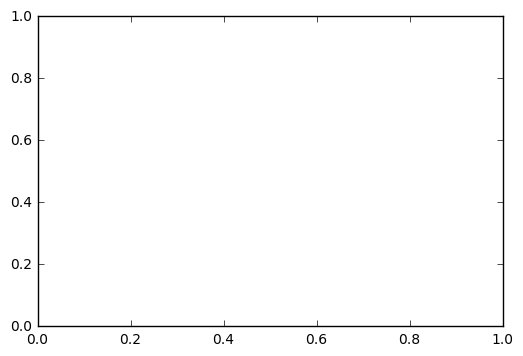

In [11]:
Stations.index.names = ['station']
s2 = Stations.reset_index()
df2=s2.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", })
pdf=pd.DataFrame(df2)

pdf.sort_values(by=['station'],inplace=True)
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');